## 1. Import Libraries

In [2]:
!pip install feature_engine

In [52]:
import pandas as pd

import numpy as np

#import matplotlib.pyplot as plt

import sklearn

import feature_engine

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    StandardScaler,
    PowerTransformer,
    FunctionTransformer
    
)
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
    
)
from feature_engine.datetime import DatetimeFeatures


import warnings

## 2. Display Settings

In [7]:
pd.set_option("display.max_columns", None) #display all columns

In [8]:
sklearn.set_config(transform_output= "pandas") #sklearn transforms otherwise return np arrays

In [9]:
warnings.filterwarnings("ignore")

## 3. Read the Data

In [10]:
path=r"C:\Users\jinni\Desktop\flights-sagemaker-project\data\train.csv"

train= pd.read_csv(path)

In [11]:
train.head(5)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-27,Delhi,Cochin,11:30:00,18:50:00,440,1.0,No Info,12242
1,Jet Airways,2019-06-12,Delhi,Cochin,02:15:00,19:00:00,1005,1.0,No Info,14714
2,Jet Airways,2019-05-18,Kolkata,Banglore,08:25:00,22:35:00,850,1.0,In-flight meal not included,10844
3,Jet Airways,2019-05-09,Kolkata,Banglore,06:30:00,16:20:00,590,1.0,In-flight meal not included,8586
4,Indigo,2019-03-27,Delhi,Cochin,06:40:00,16:10:00,570,1.0,No Info,6442


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [13]:
X_train= train.drop(columns= "price")
y_train= train.price.copy()

## 4. Transformation Operations

In [14]:
X_train.columns.to_list(
)

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

### 4.1 Airline

In [15]:
X_train.airline

0      Jet Airways
1      Jet Airways
2      Jet Airways
3      Jet Airways
4           Indigo
          ...     
635      Air India
636    Jet Airways
637      Air India
638       Air Asia
639         Indigo
Name: airline, Length: 640, dtype: object

In [16]:
X_train.airline.unique()

array(['Jet Airways', 'Indigo', 'Spicejet', 'Vistara', 'Air India',
       'Multiple Carriers', 'Air Asia', 'Goair', 'Trujet'], dtype=object)

### Note: Transformation operations for categorical column- Airline
1. Imputation
2. Group Rare Labels
3. One-hot encoding

In [17]:
air_transformer= Pipeline(steps=[ #transformation steps to be applied to this column- is a list of tuples
    ("imputer", SimpleImputer(strategy="most_frequent")), #missing values imputed
    ("grouper", RareLabelEncoder(tol=0.1, replace_with= "Other", n_categories=2)), #tolerance- group all categeories less than 10%
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown= "ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])

#pipeline used to perform transfrmations one after the other on given input- airline

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
635,1.0,0.0,0.0,0.0,0.0
636,0.0,0.0,1.0,0.0,0.0
637,1.0,0.0,0.0,0.0,0.0
638,0.0,0.0,0.0,0.0,1.0


### 4.2 date_of_journey

In [18]:
X_train.date_of_journey

0      2019-03-27
1      2019-06-12
2      2019-05-18
3      2019-05-09
4      2019-03-27
          ...    
635    2019-05-06
636    2019-03-06
637    2019-05-18
638    2019-04-21
639    2019-03-03
Name: date_of_journey, Length: 640, dtype: object

### Note: Transforms on date-time column date_of_journey
1. Date-time feature extraction
2. Min max scaling- convert all values between 0 to 1.

In [19]:
#all are year 2019, extract other features of datetime
feature_to_extract= ["month", "week", "day_of_week", "day_of_year"]

doj_transformer= Pipeline(steps= [
    ("dt", DatetimeFeatures(features_to_extract= feature_to_extract, yearfirst=True, format="mixed" ))
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])
#feature engine library works on pandas dataframe

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,3,13,2,86
1,6,24,2,163
2,5,20,5,138
3,5,19,3,129
4,3,13,2,86
...,...,...,...,...
635,5,19,0,126
636,3,10,2,65
637,5,20,5,138
638,4,16,6,111


In [20]:
#these values go from single digit to three digit- not an issue with tree based model
# for the sake of completeness-

feature_to_extract= ["month", "week", "day_of_week", "day_of_year"]

doj_transformer= Pipeline(steps= [
    ("dt", DatetimeFeatures(features_to_extract= feature_to_extract, yearfirst=True, format="mixed" )),
    ("scaler", MinMaxScaler()) #all values now between 0-1
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.235294,0.333333,0.220339
1,1.000000,0.882353,0.333333,0.872881
2,0.666667,0.647059,0.833333,0.661017
3,0.666667,0.588235,0.500000,0.584746
4,0.000000,0.235294,0.333333,0.220339
...,...,...,...,...
635,0.666667,0.588235,0.000000,0.559322
636,0.000000,0.058824,0.333333,0.042373
637,0.666667,0.647059,0.833333,0.661017
638,0.333333,0.411765,1.000000,0.432203


### 4.3 source and destination

#### Transformations-

1. *group rare labels*
2. *mean encoding* - replaces the categories by the mean value of the `target` for each category. Eg. categorical var colour- RGB and mean of the numerical target for RBG is 0.5, 0.8, 0.1-> R replaced by 0.5, G by 0.8, B by 0.1
3. *power transformer* - for scaling on numerical variable, such that the numerical var becomes as symmetric as possible. Find lambda. offered by sklearn. Performs transformation plus has `standardize= True` which hence performs scaling.
4. *is  north city*- custom transformation

In [21]:
X_train.source

0         Delhi
1         Delhi
2       Kolkata
3       Kolkata
4         Delhi
         ...   
635     Kolkata
636    Banglore
637     Kolkata
638     Kolkata
639       Delhi
Name: source, Length: 640, dtype: object

In [22]:
X_train.destination

0         Cochin
1         Cochin
2       Banglore
3       Banglore
4         Cochin
         ...    
635     Banglore
636    New Delhi
637     Banglore
638     Banglore
639       Cochin
Name: destination, Length: 640, dtype: object

In [23]:
location_subset= X_train.loc[:, ["source", "destination"]]
location_subset #columns we want to work with-same type

,source,destination
0,Delhi,Cochin
1,Delhi,Cochin
2,Kolkata,Banglore
3,Kolkata,Banglore
4,Delhi,Cochin
...,...,...
635,Kolkata,Banglore
636,Banglore,New Delhi
637,Kolkata,Banglore
638,Kolkata,Banglore


In [24]:
location_pipe1= Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with= "Other", n_categories=2)),
    ("encoder", MeanEncoder()), #needs target column as well
    ("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,1.066560,0.511903
1,1.066560,0.511903
2,-0.333656,-0.150936
3,-0.333656,-0.150936
4,1.066560,0.511903
...,...,...
635,-0.333656,-0.150936
636,-0.513470,1.781560
637,-0.333656,-0.150936
638,-0.333656,-0.150936


In [25]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
) #all cities we have

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [26]:
def is_north(X): #input is some data frame
    columns= X.columns.to_list()
    north_cities=["Delhi", "Kolkata", "Mumbai", "New delhi"]
    return( #assign to create new features or update
        X
        .assign(**{ #create features in loop
            col:X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
    )



#call the function
is_north(location_subset)
    

,source,destination
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
635,1,0
636,0,0
637,1,0
638,1,0


* general format above is

`.assign (**{
    col: operation
    for col in columns
})`

* `col: X.loc[:, col]` #accesses the col variable
* `isin(north_cities)` checks if its in the given list
* `as type int` converts true to 1, false to 0

In [27]:
# this custom transformer is not scikit compatible

def is_north(X): #input is some data frame
    columns= X.columns.to_list()
    north_cities=["Delhi", "Kolkata", "Mumbai", "New delhi"]
    return( #assign to create new features or update
        X
        .assign(**{ #create features in loop
            col:X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
    )
FunctionTransformer(func= is_north) #scikit compatible transformer

FunctionTransformer(func=<function is_north at 0x000001D59DC78F40>)

In [28]:
def is_north(X): 
    columns= X.columns.to_list()
    north_cities=["Delhi", "Kolkata", "Mumbai", "New delhi"]
    return(
        X
        .assign(**{ 
            f"{col}_is_north":X.loc[:, col].isin(north_cities).astype(int) #replace col with this
            for col in columns
        })
        .drop(columns=columns) #drop original columns
    )
FunctionTransformer(func= is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
635,1,0
636,0,0
637,1,0
638,1,0


In [29]:
# combine the two set of transformations- inbuilt (3 used) and 1 custom
# scikit learn feature union

location_transformer= FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func= is_north))
])

location_transformer.fit_transform(location_subset, y_train)

#outputs combined in one dataframe

,source,destination,source_is_north,destination_is_north
0,1.066560,0.511903,1,0
1,1.066560,0.511903,1,0
2,-0.333656,-0.150936,1,0
3,-0.333656,-0.150936,1,0
4,1.066560,0.511903,1,0
...,...,...,...,...
635,-0.333656,-0.150936,1,0
636,-0.513470,1.781560,0,0
637,-0.333656,-0.150936,1,0
638,-0.333656,-0.150936,1,0


## 4.4 dep_time and arrival_time

* Transforms-
1. date time features
2. min max scaling
________________________________
3. part of day- custom transformer
4. count encoding
5. min max scaling
________________________________

### Note: 
* `np.select` is used to run if-else-elif like conditions in a vectorised format.


In [30]:
X_train.dep_time

0      11:30:00
1      02:15:00
2      08:25:00
3      06:30:00
4      06:40:00
         ...   
635    09:25:00
636    14:05:00
637    09:50:00
638    10:20:00
639    07:20:00
Name: dep_time, Length: 640, dtype: object

In [31]:
X_train.arrival_time

0      18:50:00
1      19:00:00
2      22:35:00
3      16:20:00
4      16:10:00
         ...   
635    18:30:00
636    09:30:00
637    23:15:00
638    12:55:00
639    12:30:00
Name: arrival_time, Length: 640, dtype: object

In [32]:
time_subset= X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,11:30:00,18:50:00
1,02:15:00,19:00:00
2,08:25:00,22:35:00
3,06:30:00,16:20:00
4,06:40:00,16:10:00
...,...,...
635,09:25:00,18:30:00
636,14:05:00,09:30:00
637,09:50:00,23:15:00
638,10:20:00,12:55:00


In [33]:
time_pipe1= Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract= ["hour", "minute"])),
    ("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.478261,0.545455,0.782609,0.909091
1,0.086957,0.272727,0.826087,0.000000
2,0.347826,0.454545,0.956522,0.636364
3,0.260870,0.545455,0.695652,0.363636
4,0.260870,0.727273,0.695652,0.181818
...,...,...,...,...
635,0.391304,0.454545,0.782609,0.545455
636,0.608696,0.090909,0.391304,0.545455
637,0.391304,0.909091,1.000000,0.272727
638,0.434783,0.363636,0.521739,1.000000


In [34]:
def part_of_day(X,morning=4, noon=12, eve=16, night=20):
    columns= X.columns.to_list()
    X_temp= X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour #converting to datetime (from string)
        for col in columns                         #and also extract the hour information
    })
    
    return(
        X_temp
        .assign(**{
            f"{col}_part_of_day":np.select(
                [X_temp.loc[:, col].between(morning, noon,inclusive= "left" ),
                X_temp.loc[:, col].between(noon, eve, inclusive= "left"),
                X_temp.loc[:, col].between(eve, night, inclusive= "left")],
                ["morning", "afternoon", "evening"],
                default="night"
            
            )
            for col in columns
        })
        .drop(columns=columns) #drop originals
    )

FunctionTransformer(func= part_of_day).fit_transform(time_subset)
    

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,evening
1,night,evening
2,morning,night
3,morning,evening
4,morning,evening
...,...,...
635,morning,evening
636,afternoon,morning
637,morning,night
638,morning,afternoon


In [35]:
time_pipe2= Pipeline(steps= [
    ("part", FunctionTransformer(func= part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.788235
1,0.041667,0.788235
2,1.000000,1.000000
3,1.000000,0.788235
4,1.000000,0.788235
...,...,...
635,1.000000,0.788235
636,0.000000,0.752941
637,1.000000,1.000000
638,1.000000,0.000000


In [36]:
# combine pipe 1 and pipe 2- feature union

In [37]:
time_transformer= FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.478261,0.545455,0.782609,0.909091,1.000000,0.788235
1,0.086957,0.272727,0.826087,0.000000,0.041667,0.788235
2,0.347826,0.454545,0.956522,0.636364,1.000000,1.000000
3,0.260870,0.545455,0.695652,0.363636,1.000000,0.788235
4,0.260870,0.727273,0.695652,0.181818,1.000000,0.788235
...,...,...,...,...,...,...
635,0.391304,0.454545,0.782609,0.545455,1.000000,0.788235
636,0.608696,0.090909,0.391304,0.545455,0.000000,0.752941
637,0.391304,0.909091,1.000000,0.272727,1.000000,1.000000
638,0.434783,0.363636,0.521739,1.000000,1.000000,0.000000


### 4.5 duration

* `capping by quantiles (Winsorizer)`- for outliers
* `Imputation`- for missing values
______________

`Group 1`

1. Duration Cetegories (shrot, medium, or long flights)
2. Original Encoding (ordinal column; specify categories)
______________

`Group 2`

3. RBF percebtiles Similarity (RBF kernel)- custom class using RBF kernel- sim ilarity between duration and percentiles.
4. Power Transformer
________________

`Group 3`

5. Over arbitary minutes
_________________

`Group 4`

6. Standard scaling

In [38]:
X_train.duration

0       440
1      1005
2       850
3       590
4       570
       ... 
635     545
636    1165
637     805
638     155
639     310
Name: duration, Length: 640, dtype: int64

In [39]:
(
    X_train
    .duration
    .quantile([0.25, 0.50, 0.75])
    .values #convert to array
    #.shape #1 D array (3,)- we want refernece values to be a 2D matrix of 3x1
    .reshape (-1,1) #1 column irrespective of rows
    #.shape
) # apply this operation for every column

array([[170.],
       [495.],
       [845.]])

In [49]:
# custom RBF class- inherit from 2 base classes
# due to this inheritence, the class become scikit learn compatible class insstead of a python class

class RBFPercetileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables= None, percentiles= [0.25, 0.50, 0.75], gamma= 0.1 ):
        self.variables= variables
        self.percentiles= percentiles
        self.gamma= gamma
        
    def fit(self, X, y=None):
        if not self.variables: #if user doesn't give variables
            self.variables= X.select_dtypes(include= "number").columns.to_list()
            
        #on each variable- we are calculating percentile values - function in cell above
    
        self. reference_values_= { #dictionary col: op, for col in xyz)
            col: (
                X
                .loc[:, col]
                .quantile(self.percentiles)
                .values
                .reshape(-1,1)

            )
            for col in self.variables
        }

        return self

    
    def transform (self, X):
        objects= []
        for col in self.variables:
            columns= [f"{col}_rbf_{int(percentile*100)}" for percentile in self.percentiles ]
            obj= pd.DataFrame(
                data= rbf_kernel(X.loc[:, [col]], Y= self.reference_values_[col], gamma= self.gamma),
                columns= columns 
            )
            objects.append (obj)
        return pd.concat(objects, axis= 1) #join horizontally (axis=1) transformations for all columns

In [41]:
RBFPercetileSimilarity().fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,0.000000e+00,4.225900e-132,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000e+00,0.000000e+00,8.208500e-02
3,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000e+00,5.120990e-245,0.000000e+00
...,...,...,...
635,0.000000e+00,2.669190e-109,0.000000e+00
636,0.000000e+00,0.000000e+00,0.000000e+00
637,0.000000e+00,0.000000e+00,3.257489e-70
638,1.691898e-10,0.000000e+00,0.000000e+00


In [42]:
RBFPercetileSimilarity().fit_transform(X_train) #will identify numerical vars on its own

,duration_rbf_25,duration_rbf_50,duration_rbf_75,total_stops_rbf_25,total_stops_rbf_50,total_stops_rbf_75
0,0.000000e+00,4.225900e-132,0.000000e+00,0.904837,1.000000,1.000000
1,0.000000e+00,0.000000e+00,0.000000e+00,0.904837,1.000000,1.000000
2,0.000000e+00,0.000000e+00,8.208500e-02,0.904837,1.000000,1.000000
3,0.000000e+00,0.000000e+00,0.000000e+00,0.904837,1.000000,1.000000
4,0.000000e+00,5.120990e-245,0.000000e+00,0.904837,1.000000,1.000000
...,...,...,...,...,...,...
635,0.000000e+00,2.669190e-109,0.000000e+00,0.904837,1.000000,1.000000
636,0.000000e+00,0.000000e+00,0.000000e+00,0.904837,1.000000,1.000000
637,0.000000e+00,0.000000e+00,3.257489e-70,0.670320,0.904837,0.904837
638,1.691898e-10,0.000000e+00,0.000000e+00,1.000000,0.904837,0.904837


In [43]:
# give other percentiles
RBFPercetileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,0.000000e+00,1.000000,1.000000
1,0.000000e+00,3.257489e-70,1.000000,1.000000
2,0.000000e+00,0.000000e+00,1.000000,1.000000
3,0.000000e+00,0.000000e+00,1.000000,1.000000
4,0.000000e+00,0.000000e+00,1.000000,1.000000
...,...,...,...,...
635,0.000000e+00,0.000000e+00,1.000000,1.000000
636,0.000000e+00,0.000000e+00,1.000000,1.000000
637,0.000000e+00,0.000000e+00,0.904837,0.904837
638,0.000000e+00,0.000000e+00,0.904837,0.904837


In [44]:
duration_pipe1= Pipeline(steps=[
    ("rbf", RBFPercetileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_union= FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),
    ("part2", StandardScaler())
])

duration_transformer= Pipeline(steps=[
    ("outiers", Winsorizer(capping_method="iqr", fold=1.5)),
    ("imputer", SimpleImputer(strategy= "median")),
    ("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration
0,-0.356437,-0.112728,-0.126179,-0.326389
1,-0.356437,-0.112728,-0.126179,0.853332
2,-0.356437,-0.112728,7.937200,0.529692
3,-0.356437,-0.112728,-0.126179,-0.013189
4,-0.356437,-0.112728,-0.126179,-0.054949
...,...,...,...,...
635,-0.356437,-0.112728,-0.126179,-0.107149
636,-0.356437,-0.112728,-0.126179,1.187412
637,-0.356437,-0.112728,-0.126179,0.435732
638,-0.356437,-0.112728,-0.126179,-0.921469


In [45]:
def duration_category(X, short=180, med=400):
     return (
        X
        .assign(duration_cat=np.select([X.duration.lt(short), #lt- less than
                                        X.duration.between(short, med, inclusive="left")],
                                       ["short", "medium"],
                                       default="long"))
        .drop(columns="duration")
    )

In [54]:
def is_over(X, value=1000): #binary column for if duration is >1000 or not
    return (
        X
        .assign(**{
            f"duration_over_{value}": X.duration.ge(value).astype(int)
        }) #ge= greater than or equal to
        .drop(columns="duration")
    )

In [53]:
duration_pipe1 = Pipeline(steps=[
    ("rbf", RBFPercetileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
    ("cat", FunctionTransformer(func=duration_category)),
    ("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3", FunctionTransformer(func=is_over)),
    ("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
    ("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
    ("imputer", SimpleImputer(strategy="median")),
    ("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.356437,-0.112728,-0.126179,2.0,0,-0.326389
1,-0.356437,-0.112728,-0.126179,2.0,1,0.853332
2,-0.356437,-0.112728,7.937200,2.0,0,0.529692
3,-0.356437,-0.112728,-0.126179,2.0,0,-0.013189
4,-0.356437,-0.112728,-0.126179,2.0,0,-0.054949
...,...,...,...,...,...,...
635,-0.356437,-0.112728,-0.126179,2.0,0,-0.107149
636,-0.356437,-0.112728,-0.126179,2.0,1,1.187412
637,-0.356437,-0.112728,-0.126179,2.0,0,0.435732
638,-0.356437,-0.112728,-0.126179,0.0,0,-0.921469


## 4.6 total_stops
* Imputation - for missing values
* is Direct Flight- identitify

In [57]:
X_train.total_stops

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
635    1.0
636    1.0
637    2.0
638    0.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [58]:
def is_direct(X):
    return X.assign(is_direct_flight= X.total_stops.eq(0).astype(int))


total_stops_transformer= Pipeline(steps=[
    ("imputer", SimpleImputer(strategy= "most_frequent")),
    ("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,1.0,0
3,1.0,0
4,1.0,0
...,...,...
635,1.0,0
636,1.0,0
637,2.0,0
638,0.0,1


## 4.7 additional_info
* Imputation
______
1. Group rare labels
2. One hot encoding

_____

3. Have info

In [59]:
X_train.additional_info

0                          No Info
1                          No Info
2      In-flight meal not included
3      In-flight meal not included
4                          No Info
                  ...             
635                        No Info
636                        No Info
637                        No Info
638                        No Info
639                        No Info
Name: additional_info, Length: 640, dtype: object

In [60]:
info_pipe1 = Pipeline(steps=[
    ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [61]:
def have_info(X): #binary column again- if no info= 0
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [62]:
info_union = FeatureUnion(transformer_list=[
    ("part1", info_pipe1),
    ("part2", FunctionTransformer(func=have_info))
])

In [63]:

info_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,1.0,0.0,0.0,1
3,1.0,0.0,0.0,1
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


## 5. Column Transformer

In [64]:
# input is list of tuples 
# each tuple has 1. a given name "air", 2. transformers to be applied 3. input column




column_transformer= ColumnTransformer(transformers= [
    ("air", air_transformer, ["airline"])
    
])
column_transformer.fit_transform(X_train)




#gave full dataset but output is only airline transformations- due to columnTransformer


,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
635,1.0,0.0,0.0,0.0,0.0
636,0.0,0.0,1.0,0.0,0.0
637,1.0,0.0,0.0,0.0,0.0
638,0.0,0.0,0.0,0.0,1.0


In [65]:
# to show other columns- remainder passthrough

column_transformer= ColumnTransformer(transformers= [
    ("air", air_transformer, ["airline"]),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("location", location_transformer, ["source", "destination"]),
    ("time", time_transformer, ["dep_time", "arrival_time"]),
    ("dur", duration_transformer, ["duration"]),
    ("stops", total_stops_transformer, ["total_stops"]),
    ("info", info_transformer, ["additional_info"])
    
], remainder= "passthrough")
                                      
column_transformer.fit_transform(X_train, y_train)

#gives 13 columns instead of only 5 of airline
# increased to 16 after doj (date of journey) transformers

# column size will keep on increasing as we add new transforms on features

# at the end has 31 columns

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.000000,0.235294,0.333333,0.220339,1.066560,0.511903,1,0,0.478261,0.545455,0.782609,0.909091,1.000000,0.788235,-0.356437,-0.112728,-0.126179,2.0,0,-0.326389,1.0,0,0.0,1.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,1.066560,0.511903,1,0,0.086957,0.272727,0.826087,0.000000,0.041667,0.788235,-0.356437,-0.112728,-0.126179,2.0,1,0.853332,1.0,0,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,-0.333656,-0.150936,1,0,0.347826,0.454545,0.956522,0.636364,1.000000,1.000000,-0.356437,-0.112728,7.937200,2.0,0,0.529692,1.0,0,1.0,0.0,0.0,1
3,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,0.500000,0.584746,-0.333656,-0.150936,1,0,0.260870,0.545455,0.695652,0.363636,1.000000,0.788235,-0.356437,-0.112728,-0.126179,2.0,0,-0.013189,1.0,0,1.0,0.0,0.0,1
4,0.0,1.0,0.0,0.0,0.0,0.000000,0.235294,0.333333,0.220339,1.066560,0.511903,1,0,0.260870,0.727273,0.695652,0.181818,1.000000,0.788235,-0.356437,-0.112728,-0.126179,2.0,0,-0.054949,1.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1.0,0.0,0.0,0.0,0.0,0.666667,0.588235,0.000000,0.559322,-0.333656,-0.150936,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.788235,-0.356437,-0.112728,-0.126179,2.0,0,-0.107149,1.0,0,0.0,1.0,0.0,0
636,0.0,0.0,1.0,0.0,0.0,0.000000,0.058824,0.333333,0.042373,-0.513470,1.781560,0,0,0.608696,0.090909,0.391304,0.545455,0.000000,0.752941,-0.356437,-0.112728,-0.126179,2.0,1,1.187412,1.0,0,0.0,1.0,0.0,0
637,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,-0.333656,-0.150936,1,0,0.391304,0.909091,1.000000,0.272727,1.000000,1.000000,-0.356437,-0.112728,-0.126179,2.0,0,0.435732,2.0,0,0.0,1.0,0.0,0
638,0.0,0.0,0.0,0.0,1.0,0.333333,0.411765,1.000000,0.432203,-0.333656,-0.150936,1,0,0.434783,0.363636,0.521739,1.000000,1.000000,0.000000,-0.356437,-0.112728,-0.126179,0.0,0,-0.921469,0.0,1,0.0,1.0,0.0,0


In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


## 6. Feature Selection

In [66]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance( #each feature compared with price and max performance features selected
    estimator=estimator,
    scoring="r2",
    threshold=0.1 #reatin features with r2 score >= 0.1
)

## 7. Put everything together

In [67]:
preprocessor = Pipeline(steps=[ #final preprocessor
    ("ct", column_transformer),
    ("selector", selector)
])

preprocessor.fit_transform(X_train, y_train) #retains 12 out of 31 columns

,air__airline_Indigo,air__airline_Jet Airways,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__destination_is_north,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.235294,0.220339,1.066560,0.511903,0,2.0,0,-0.326389,1.0,0
1,0.0,1.0,0.882353,0.872881,1.066560,0.511903,0,2.0,1,0.853332,1.0,0
2,0.0,1.0,0.647059,0.661017,-0.333656,-0.150936,0,2.0,0,0.529692,1.0,0
3,0.0,1.0,0.588235,0.584746,-0.333656,-0.150936,0,2.0,0,-0.013189,1.0,0
4,1.0,0.0,0.235294,0.220339,1.066560,0.511903,0,2.0,0,-0.054949,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.588235,0.559322,-0.333656,-0.150936,0,2.0,0,-0.107149,1.0,0
636,0.0,1.0,0.058824,0.042373,-0.513470,1.781560,0,2.0,1,1.187412,1.0,0
637,0.0,0.0,0.647059,0.661017,-0.333656,-0.150936,0,2.0,0,0.435732,2.0,0
638,0.0,0.0,0.411765,0.432203,-0.333656,-0.150936,0,0.0,0,-0.921469,0.0,1


## 8. Visualisations

In [68]:
preprocessor

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   Datetime...
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x000001D59DE1F240>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

In [69]:
preprocessor.named_steps #shows everything

{'ct': ColumnTransformer(remainder='passthrough',
                   transformers=[('air',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('grouper',
                                                   RareLabelEncoder(n_categories=2,
                                                                    replace_with='Other',
                                                                    tol=0.1)),
                                                  ('encoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse_output=False))]),
                                  ['airline']),
                                 ('doj',
                                  Pipeline(steps=[('dt',
                                                   

In [70]:
preprocessor.named_steps.keys() #shows 2 major components- ct and selector

dict_keys(['ct', 'selector'])

In [71]:
#we want to access selector only
preprocessor.named_steps["selector"]

SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                 n_estimators=10,
                                                                 random_state=42),
                                 scoring='r2', threshold=0.1)

In [72]:
#each selector object has attribute- feature importance (stores column and its r2 score)
preprocessor.named_steps["selector"].feature_performance_

{'air__airline_Air India': 0.008351716936632725,
 'air__airline_Indigo': 0.1363960005244924,
 'air__airline_Jet Airways': 0.16267645145316778,
 'air__airline_Multiple Carriers': 0.01653150070845862,
 'air__airline_Other': 0.09679478527371177,
 'doj__date_of_journey_month': 0.06856104291152654,
 'doj__date_of_journey_week': 0.11142916425485805,
 'doj__date_of_journey_day_of_week': -0.018968795249913056,
 'doj__date_of_journey_day_of_year': 0.14480694593938237,
 'location__source': 0.11070295312867191,
 'location__destination': 0.24508211648133835,
 'location__source_is_north': -0.0006233047740386022,
 'location__destination_is_north': 0.12153513356048991,
 'time__dep_time_hour': -0.010227401450056739,
 'time__dep_time_minute': 0.035488509160853145,
 'time__arrival_time_hour': 0.018191689659283455,
 'time__arrival_time_minute': 0.024412452564975817,
 'time__dep_time_part_of_day': -0.008667641299478687,
 'time__arrival_time_part_of_day': 0.0007880732981182156,
 'dur__duration_rbf_25': 0.0

In [77]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances
#features that were kept

{'air__airline_Air India': 0.008351716936632725,
 'air__airline_Indigo': 0.1363960005244924,
 'air__airline_Jet Airways': 0.16267645145316778,
 'air__airline_Multiple Carriers': 0.01653150070845862,
 'air__airline_Other': 0.09679478527371177,
 'doj__date_of_journey_month': 0.06856104291152654,
 'doj__date_of_journey_week': 0.11142916425485805,
 'doj__date_of_journey_day_of_week': -0.018968795249913056,
 'doj__date_of_journey_day_of_year': 0.14480694593938237,
 'location__source': 0.11070295312867191,
 'location__destination': 0.24508211648133835,
 'location__source_is_north': -0.0006233047740386022,
 'location__destination_is_north': 0.12153513356048991,
 'time__dep_time_hour': -0.010227401450056739,
 'time__dep_time_minute': 0.035488509160853145,
 'time__arrival_time_hour': 0.018191689659283455,
 'time__arrival_time_minute': 0.024412452564975817,
 'time__dep_time_part_of_day': -0.008667641299478687,
 'time__arrival_time_part_of_day': 0.0007880732981182156,
 'dur__duration_rbf_25': 0.0

In [78]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp
#sort the dictionary based on value

{'doj__date_of_journey_day_of_week': -0.018968795249913056,
 'dur__duration_rbf_50': -0.010491844477017084,
 'time__dep_time_hour': -0.010227401450056739,
 'time__dep_time_part_of_day': -0.008667641299478687,
 'info__additional_info_No Info': -0.0071795337251424245,
 'info__additional_info': -0.0071795337251424245,
 'dur__duration_rbf_75': -0.001959913538514102,
 'location__source_is_north': -0.0006233047740386022,
 'info__additional_info_In-flight meal not included': 0.0007115516433463901,
 'time__arrival_time_part_of_day': 0.0007880732981182156,
 'air__airline_Air India': 0.008351716936632725,
 'air__airline_Multiple Carriers': 0.01653150070845862,
 'time__arrival_time_hour': 0.018191689659283455,
 'time__arrival_time_minute': 0.024412452564975817,
 'info__additional_info_Other': 0.028707203254738894,
 'time__dep_time_minute': 0.035488509160853145,
 'doj__date_of_journey_month': 0.06856104291152654,
 'dur__duration_rbf_25': 0.08038964963011508,
 'air__airline_Other': 0.09679478527371

In [ ]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

* expected output 
*fix pillow dll issue
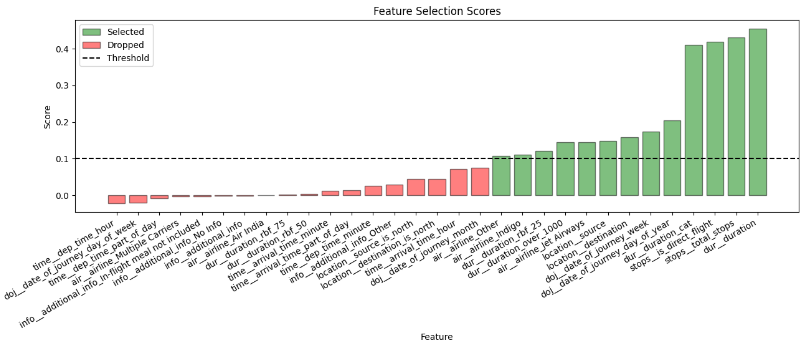


1.  The dataset went upto 31 columns after feature engineering.
2. The feature selection algotithm selected 13 features out of that.